Plot the monthly mean SST and compute time series over region of interest.

In [22]:
import sys
sys.path.insert(0, '..')
import os
import glob
import numpy as np
from filament import filament
import datetime
import cmocean
import logging
import netCDF4
import calendar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.dates as mdates
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cartopyticker
import matplotlib.ticker as mticker
coast = cfeature.GSHHSFeature(scale="f")
from importlib import reload
reload(filament)
plt.rcParams.update({'font.size': 18})
from matplotlib.font_manager import FontProperties
plt.rc("font", family="Times New Roman", size=16)
fp2 = FontProperties(fname="/home/ctroupin/.fonts/Barlow-Regular.ttf")

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Starting")

INFO:root:Starting


In [39]:
yearlist = range(2000, 2023)
sat = "TERRA"
sensor = "MODIS"
figdir = "/home/ctroupin/data/SST/Global/figures/time_series/"
climdir = "/home/ctroupin/data/SST/Global/monthly_clim/"
monthlydir = "/home/ctroupin/data/SST/Global/monthly"
if not os.path.exists(figdir):
    os.makedirs(figdir)

bgcolor = "black"
fgcolor = "white"

col1 = "#E00707"
col2 = "#3075A6"

In [13]:
regions_coords = {"MedSea": (-7, 17, 30., 48.),
                  "Canary": (-18.5, -13., 27.5, 29.5),
                  "Atlantic": (-80., 0., 0., 40.),
                  "Balearic": (1., 4.5, 38.5, 40.25),}
regionname = "Canary"
coordinates = regions_coords[regionname]
coordinates2 = (coordinates[0] - 0.5, coordinates[1] + 0.5, coordinates[2] - 0.5, coordinates[3] + 0.5)
myproj = cartopy.crs.Mercator(central_longitude=0.5 * (coordinates[0] + coordinates[1]), 
                              min_latitude=coordinates[2], max_latitude=coordinates[3], 
                              globe=None, latitude_true_scale=None)
data_crs = ccrs.PlateCarree()

In [14]:
def add_island_names(ax, name="Canary"):
    plotkwargs = dict(transform=data_crs, ha="center", fontsize=16, zorder=7, color=".3", 
                      fontproperties=fp2)
    
    if name == "Canary":
        ax.text(-15.5917, 27.875, "Gran Canaria", **plotkwargs)
        ax.text(-16.573, 28.222, "Tenerife", **plotkwargs)
        ax.text(-17.8391, 28.9, "La Palma", **plotkwargs)
        ax.text(-18.0093, 27.525, "El Hierro", **plotkwargs)
        ax.text(-17.2252, 27.875, "La Gomera", **plotkwargs)
        ax.text(-14.013, 28.411, "Fuerteventura", **plotkwargs)
        ax.text(-13.672, 29.027, "Lanzarote", **plotkwargs)
    
    elif name == "Balearic":
        ax.text(4.0375, 39.95, "Menorca", **plotkwargs)
        ax.text(2.9649, 39.7241, "Mallorca", **plotkwargs)
        ax.text(1.425, 38.975, "Ibiza", **plotkwargs)

## General map 
To see the region of interest.

In [15]:
def make_bathy_map(myproj, coordinates, regionname="Canary", figname=""):
    
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection=myproj)     

    # EMODnet bathymetry
    ax.add_wms(wms='http://ows.emodnet-bathymetry.eu/wms',
                   layers=['emodnet:mean_atlas_land', 'coastlines'],
                   transform=myproj, zorder=3)

    # Grid lines and labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=.5, color='gray', alpha=0.5, linestyle='-', zorder=6)

    gl.top_labels = False
    gl.right_labels = False

    if regionname == "Canary":
            gl.xlocator = mticker.FixedLocator(np.arange(-20., -10., 1.))
            gl.ylocator = mticker.FixedLocator(np.arange(26., 31., 0.5))
    elif regionname == "Balearic": 
        gl.xlocator = mticker.FixedLocator(np.arange(1., 4.50001, 0.5))
        gl.ylocator = mticker.FixedLocator(np.arange(38.5, 40.25, 0.5))

    add_island_names(ax, name=regionname)
    
    # Domain extension
    ax.set_extent(coordinates)

    if len(figname) > 0:
        plt.savefig(figname, dpi=300, bbox_inches="tight")
    else:
        plt.show()
    plt.close()

In [23]:
fname = f"SST_{regionname}_00.jpg"
figname = os.path.join(figdir, fname)
make_bathy_map(myproj, coordinates2, regionname=regionname, figname=figname)

### Loop on the files to extract mean

In [26]:
def compute_SST_date(yearlist, basedir=monthlydir):
    nyears = len(yearlist)
    year0 = yearlist[0]
    SSTmax = 0.
    SSTmin = 30.
    SSTarray = np.zeros((nyears, 12))
    datearray = []
    for yyyy, year in enumerate(yearlist):
        monthlydir = f"{basedir}/{year}"
        
        for imonth in range(1, 13):

            datearray.append(datetime.date(year, imonth, 1))
            sstmonthfile = filament.get_monthly_filename(sat, sensor, year, imonth, res="9km")
            sstmonthfile = os.path.join(monthlydir, sstmonthfile)

            if os.path.exists(sstmonthfile):

                # Read data (lon, lat and SST)
                SSTmonth = filament.SST()
                SSTmonth.read_from_oceancolorL3(sstmonthfile, domain=coordinates2)
                SSTarray[yyyy, imonth-1] = SSTmonth.field.mean()

                if year > 2000:
                    if SSTmonth.field.max() > SSTmax:
                        SSTmax = SSTmonth.field.max()
                        monthmax = imonth
                        yearmax = year

                    if SSTmonth.field.min() < SSTmin:
                        SSTmin = SSTmonth.field.min()
                        monthmin = imonth
                        yearmin = year
            else:
                print(f"{yyyy} - {imonth} File {sstmonthfile} does not exit")
                
    return datearray, SSTarray, SSTmax, SSTmin, yearmax, yearmin, monthmax, monthmin

In [27]:
datearray, SSTarray, SSTmax, SSTmin, yearmax, yearmin, monthmax, monthmin = compute_SST_date(yearlist)
SSTmax, yearmax, monthmax, SSTmin, yearmin, monthmin

0 - 1 File /home/ctroupin/data/SST/Global/monthly/2000/TERRA_MODIS.20000101_20000131.L3m.MO.SST4.sst4.9km.nc does not exit
22 - 9 File /home/ctroupin/data/SST/Global/monthly/2022/TERRA_MODIS.20220901_20220930.L3m.MO.SST4.sst4.9km.nc does not exit
22 - 10 File /home/ctroupin/data/SST/Global/monthly/2022/TERRA_MODIS.20221001_20221031.L3m.MO.SST4.sst4.9km.nc does not exit
22 - 11 File /home/ctroupin/data/SST/Global/monthly/2022/TERRA_MODIS.20221101_20221130.L3m.MO.SST4.sst4.9km.nc does not exit
22 - 12 File /home/ctroupin/data/SST/Global/monthly/2022/TERRA_MODIS.20221201_20221231.L3m.MO.SST4.sst4.9km.nc does not exit


(25.574999, 2015, 9, 15.054999, 2018, 5)

### Compute mean, min and max temperature (overall and monthly)

In [28]:
SSTmeanYear = np.nanmean(SSTarray, axis=1)
indmin = np.argmin(SSTmeanYear[1:-1]) + 1
indmax = np.argmax(SSTmeanYear[1:-1]) + 1
logger.info(f"Warmest year {yearlist[indmax]}, coolest year {yearlist[indmin]}")

INFO:root:Warmest year 2010, coolest year 2018


In [29]:
nyears = len(yearlist)
months = np.arange(1, 13)
SSTarray[SSTarray == 0.] = np.nan

indSSTmax = np.nanargmax(SSTarray)
indSSTmin = np.nanargmin(SSTarray)
yearmax, monthmax = np.unravel_index(indSSTmax, (nyears, 12))
yearmin, monthmin = np.unravel_index(indSSTmin, (nyears, 12))
SSTmax = np.round(SSTarray[yearmax, monthmax], 1)
SSTmin = np.round(SSTarray[yearmin, monthmin], 1)

## Plots
### Time series

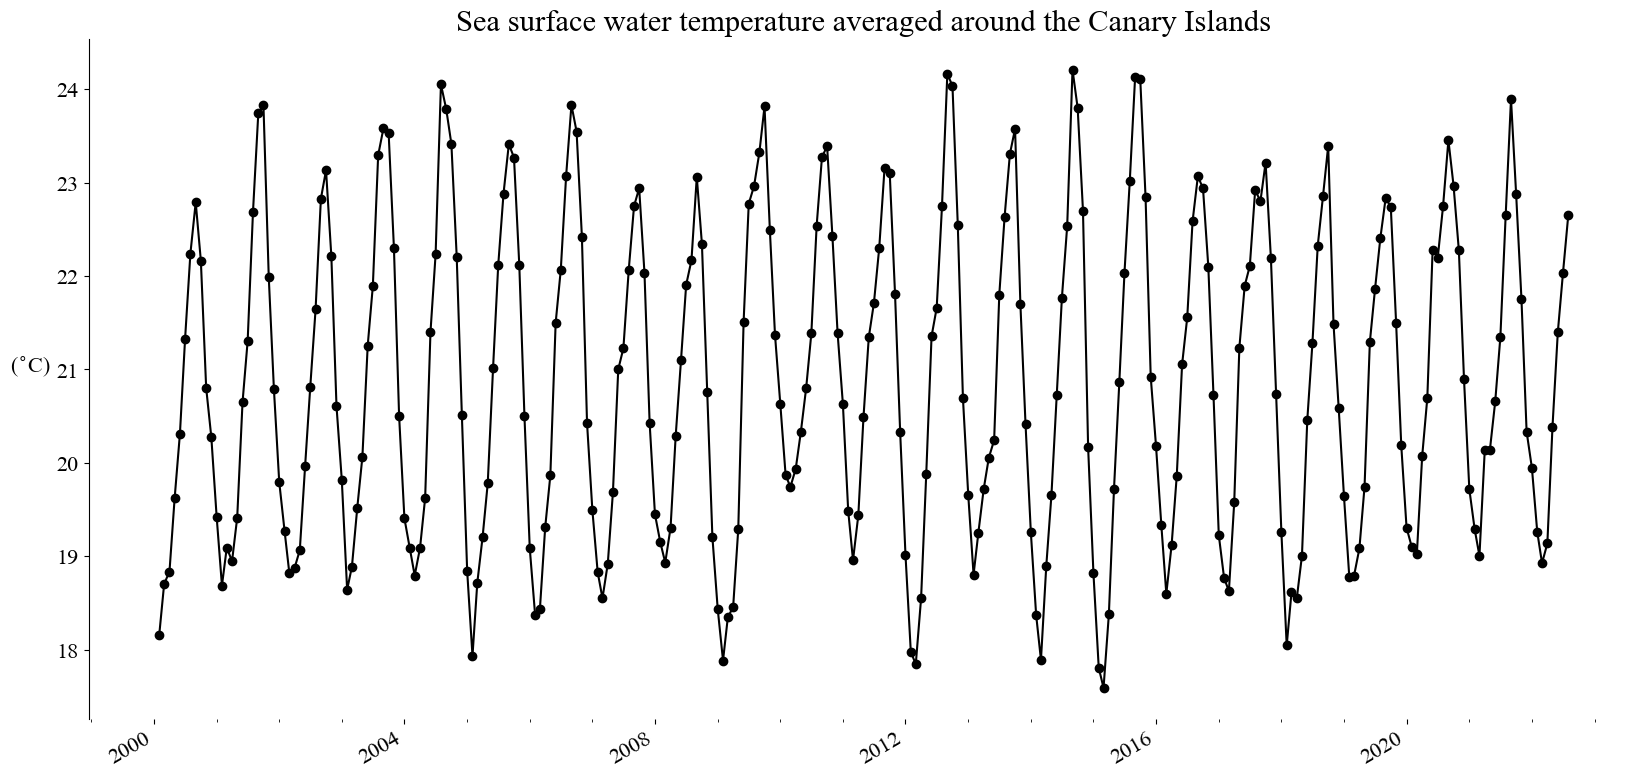

In [31]:
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

ax.set_ylabel("($^{\circ}$C)", rotation=0, ha='right')

fmt_= mdates.YearLocator()
ax.xaxis.set_minor_locator(fmt_)
fig.autofmt_xdate()
#ax.set_xlim(.9, 12.1)
#ax.set_ylim(13., 29.)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title(f"Sea surface water temperature averaged around the {regionname} Islands", fontsize=22)


plt.plot(datearray, SSTarray.flatten(), "o-", color="k")

fname = f"SST_{regionname}_01.jpg"
plt.savefig(os.path.join(figdir, fname), dpi=300, bbox_inches="tight")

plt.show()

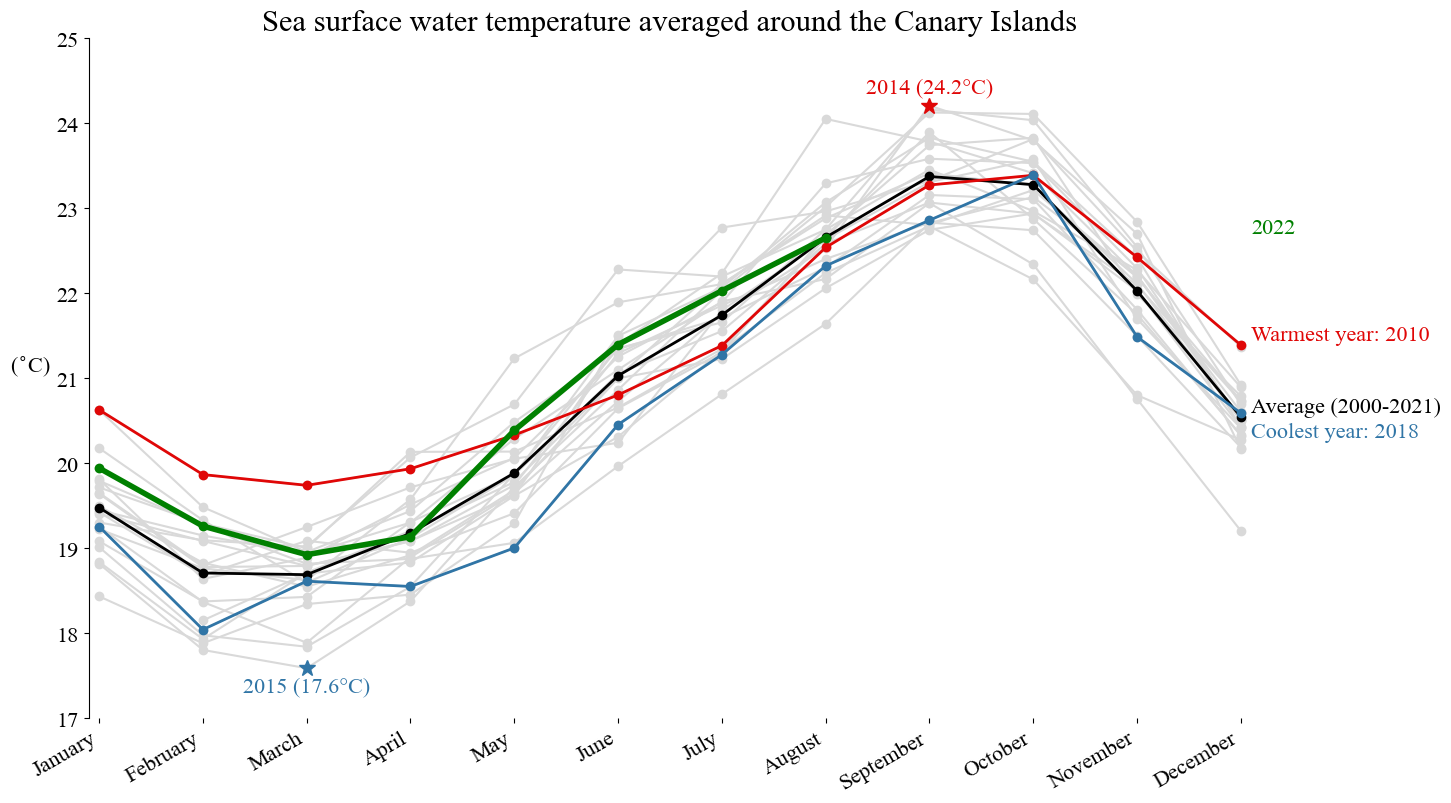

In [50]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(111)

ax.set_ylabel("($^{\circ}$C)", rotation=0, ha='right')
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(["January", "February", "March", "April", "May", 
                  "June", "July", "August", "September",
                  "October", "November", "December"])
fig.autofmt_xdate()
ax.set_xlim(.9, 12.1)
ax.set_ylim(17., 25.)
#ax.set_ylim(13., 29.)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title(f"Sea surface water temperature averaged around the {regionname} Islands", fontsize=22)


plt.plot(months, SSTarray.transpose(), "o-", color=".85")
fname = f"SST_{regionname}_02.jpg"
plt.savefig(os.path.join(figdir, fname), dpi=300, bbox_inches="tight")

plt.plot(months, np.nanmean(SSTarray[0:-1,:], axis=0), "ko-", lw=2.)
plt.text(12.1, np.nanmean(SSTarray[0:-1,:], axis=0)[-1], "Average (2000-2021)", color="k", va="bottom")
fname = f"SST_{regionname}_03.jpg"
plt.savefig(os.path.join(figdir, fname), dpi=300, bbox_inches="tight")

plt.plot(months, SSTarray[indmax, :], "o-", color=col1, lw=2.)

plt.text(12.1, SSTarray[indmax, -1], f"Warmest year: {yearlist[indmax]}", color=col1, va="bottom")

fname = f"SST_{regionname}_04.jpg"
plt.savefig(os.path.join(figdir, fname), dpi=300, bbox_inches="tight")

plt.plot(months, SSTarray[indmin, :], "o-", color=col2, lw=2.)

plt.text(12.1, SSTarray[indmin, -1] - 0.1, f"Coolest year: {yearlist[indmin]}", color=col2, va="top")

fname = f"SST_{regionname}_05.jpg"
plt.savefig(os.path.join(figdir, fname), dpi=300, bbox_inches="tight")

plt.plot(months[monthmax], SSTarray[yearmax, monthmax], "*", color=col1, ms=12)
plt.text(months[monthmax], SSTarray[yearmax, monthmax] + 0.1, f"{yearlist[yearmax]} ({SSTmax}°C)", 
         va="bottom", ha="center", color=col1)

fname = f"SST_{regionname}_06.jpg"
plt.savefig(os.path.join(figdir, fname), dpi=300, bbox_inches="tight")

plt.plot(months[monthmin], SSTarray[yearmin, monthmin], "*", color=col2, ms=12)
plt.text(months[monthmin], SSTarray[yearmin, monthmin] - 0.1, f"{yearlist[yearmin]} ({SSTmin}°C)", 
         va="top", ha="center", color=col2)

fname = f"SST_{regionname}_07.jpg"
plt.savefig(os.path.join(figdir, fname), dpi=300, bbox_inches="tight")

plt.plot(months, SSTarray[-1, :], "o-", color="g", lw=4.)
plt.text(12.1, SSTarray[-1, 7], f"2022", color="g", va="bottom")

fname = f"SST_{regionname}_07b.jpg"
plt.savefig(os.path.join(figdir, fname), dpi=300, bbox_inches="tight")

plt.show()

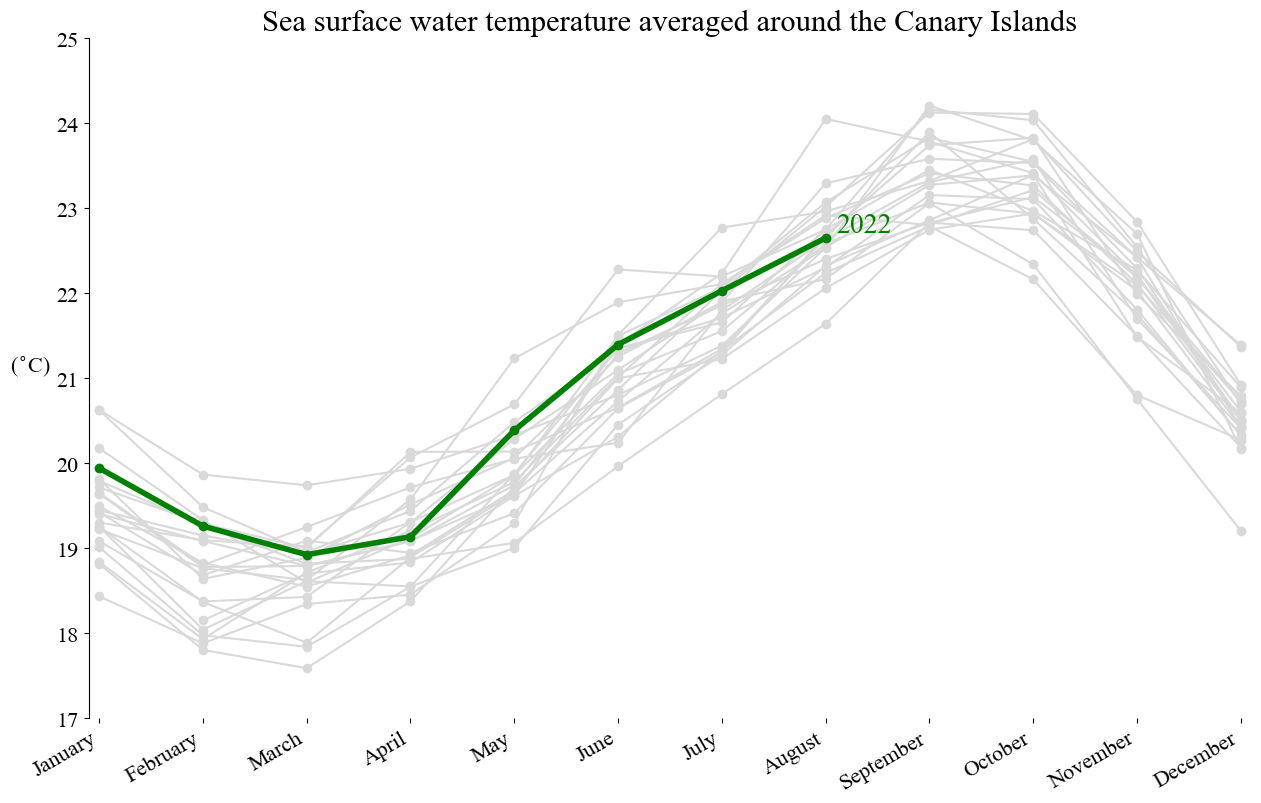

In [56]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(111)

ax.set_ylabel("($^{\circ}$C)", rotation=0, ha='right')
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(["January", "February", "March", "April", "May", 
                  "June", "July", "August", "September",
                  "October", "November", "December"])
fig.autofmt_xdate()
ax.set_xlim(.9, 12.1)
ax.set_ylim(17., 25.)
#ax.set_ylim(13., 29.)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title(f"Sea surface water temperature averaged around the {regionname} Islands", fontsize=22)


plt.plot(months, SSTarray.transpose(), "o-", color=".85")


plt.plot(months, SSTarray[-1, :], "o-", color="g", lw=4.)
plt.text(8.1, SSTarray[-1, 7], f"2022", color="g", va="bottom", fontsize=20)

fname = f"SST_{regionname}_07b.jpg"
plt.savefig(os.path.join(figdir, fname), dpi=300, bbox_inches="tight")

plt.show()

array([19.94463524, 19.26253407, 18.92608106, 19.13714341, 20.38834175,
       21.39834442, 22.0306356 , 22.65271141,         nan,         nan,
               nan,         nan])

In [33]:
logger.info(f"Lowest temperature: {np.nanmin(SSTarray)}")

INFO:root:Lowest temperature: 17.59068381941856


## 2D plots

In [34]:
def get_year_stard_end(year, month):
    # Get min SST field
    if month == 1:
        yearstart = 2001
    else: 
        yearstart = 2000
    if month <= 8:
        yearend = 2022
    else:
        yearend = 2021
    return yearstart, yearend

In [35]:
def plot_sst_month(SST, figname="", vmin=18., vmax=25., clim=False, regionname="Canary"):
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection=myproj)
    
    if clim:
        plt.title(SST.date.strftime("%B"), fontsize=24)
    else:
        plt.title(SST.date.strftime("%B %Y"), fontsize=24)

    pcm = ax.pcolormesh(SST.lon, SST.lat, SST.field, cmap=plt.cm.RdYlBu_r, 
                        transform=data_crs, zorder=2, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(pcm, shrink=.35, extend="both")

    # Grid lines and labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=.5, color='gray', alpha=0.5, linestyle='-', zorder=3)
    cb.set_label("(°C)", rotation=0, ha="left")

    gl.top_labels = False
    gl.right_labels = False
    
    if regionname == "Canary":
        gl.xlocator = mticker.FixedLocator(np.arange(-20., -10., 1.))
        gl.ylocator = mticker.FixedLocator(np.arange(26., 31., 0.5))
    elif regionname == "Balearic": 
        gl.xlocator = mticker.FixedLocator(np.arange(1., 4.50001, 0.5))
        gl.ylocator = mticker.FixedLocator(np.arange(38.5, 40.25, 0.5))

    ax.add_feature(coast, linewidth=.2, color=".85", zorder=5)

    # Domain extension
    ax.set_extent(coordinates)

    if len(figname) > 0:
        plt.savefig(figname, dpi=300, bbox_inches="tight")
    else:
        plt.show()
        
    plt.close()

In [36]:
def plot_sst_anomaly(SST1, SST2, figname="", vmin=-2.5, vmax=2.5, clim=False, regionname="Canary",
                     cmap=plt.cm.RdBu_r):
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes(projection=myproj)
   
    plt.title(SST1.date.strftime("%B %Y"), fontsize=24)

    pcm = ax.pcolormesh(SST1.lon, SST1.lat, SST1.field - SST2.field, cmap=cmap, 
                        transform=data_crs, zorder=2, vmin=vmin, vmax=vmax)
    
    if vmin==0.:
        cb = plt.colorbar(pcm, shrink=.35, extend="max")
    elif vmax==0.:
        cb = plt.colorbar(pcm, shrink=.35, extend="min")
    else:
        cb = plt.colorbar(pcm, shrink=.35, extend="both")

    # Grid lines and labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=.5, color='gray', alpha=0.5, linestyle='-', zorder=3)
    cb.set_label("(°C)", rotation=0, ha="left")

    gl.top_labels = False
    gl.right_labels = False
    
    if regionname == "Canary":
        gl.xlocator = mticker.FixedLocator(np.arange(-20., -10., 1.))
        gl.ylocator = mticker.FixedLocator(np.arange(26., 31., 0.5))
    elif regionname == "Balearic": 
        gl.xlocator = mticker.FixedLocator(np.arange(1., 4.50001, 0.5))
        gl.ylocator = mticker.FixedLocator(np.arange(38.5, 40.25, 0.5))

    ax.add_feature(coast, linewidth=.2, color=".85", zorder=5)

    # Domain extension
    ax.set_extent(coordinates)

    if len(figname) > 0:
        plt.savefig(figname, dpi=300, bbox_inches="tight")
    else:
        plt.show()
        
    plt.close()

### Warmest month

In [40]:
year = yearlist[yearmax]
month = months[monthmax]
yearstart, yearend = get_year_stard_end(year, month)

# Get max SST field
monthlydir = f"{monthlydir}/{year}"
sstmonthfile = filament.get_monthly_filename(sat, sensor, year, month, res="9km")
sstmonthfile = os.path.join(monthlydir, sstmonthfile)
sstclimfile = filament.get_monthly_clim_filename(sat, sensor, yearstart, yearend, month, res="9km")
sstclimfile = os.path.join(climdir, sstclimfile)

SSTmonthmax = filament.SST()
SSTmonthmax.read_from_oceancolorL3(sstmonthfile, domain=coordinates2)
SSTclimmax = filament.SST()
SSTclimmax.read_from_oceancolorL3(sstclimfile, domain=coordinates2)

In [44]:
fname = f"SST_{regionname}_08.jpg"
plot_sst_month(SSTmonthmax, figname=os.path.join(figdir, fname), vmin=22., vmax=25)

In [45]:
fname = f"SST_{regionname}_09.jpg"
plot_sst_month(SSTclimmax, figname=os.path.join(figdir, fname), clim=True, vmin=22., vmax=25.)

In [43]:
fname = f"SST_{regionname}_10.jpg"
plot_sst_anomaly(SSTmonthmax, SSTclimmax, figname=os.path.join(figdir, fname), vmin=0., vmax=2., 
                 cmap=plt.cm.Reds,
                 regionname="Balearic")

### Coolest month

In [ ]:
year = yearlist[yearmin]
month = months[monthmin]
yearstart, yearend = get_year_stard_end(year, month)

monthlydir = "/data/SST/Global/monthly/{}".format(year)
sstmonthfile = filament.get_monthly_filename(sat, sensor, year, 
                                             month, res="9km")
sstmonthfile = os.path.join(monthlydir, sstmonthfile)
sstclimfile = filament.get_monthly_clim_filename(sat, sensor, yearstart, yearend, 
                                                 month, res="9km")
sstclimfile = os.path.join(climdir, sstclimfile)

SSTmonthmin = filament.SST()
SSTmonthmin.read_from_oceancolorL3(sstmonthfile, domain=coordinates2)
SSTclimmin = filament.SST()
SSTclimmin.read_from_oceancolorL3(sstclimfile, domain=coordinates2)

In [ ]:
fname = f"SST_{regionname}_11.jpg"
plot_sst_month(SSTmonthmin, figname=os.path.join(figdir, fname), vmin=12., vmax=14.)

In [ ]:
fname = f"SST_{regionname}_12.jpg"
plot_sst_month(SSTclimmin, figname=os.path.join(figdir, fname), vmin=13.5, vmax=15., clim=True)

In [ ]:
fname = f"SST_{regionname}_13.jpg"
plot_sst_anomaly(SSTmonthmin, SSTclimmin, vmin=-2., vmax=0,
                 cmap=plt.cm.Blues_r, figname=os.path.join(figdir, fname),
                 regionname="Balearic")

### Warmest loc

In [ ]:
year = 2003
month = 8
yearstart, yearend = get_year_stard_end(year, month)

monthlydir = "/data/SST/Global/monthly/{}".format(year)
sstmonthfile = filament.get_monthly_filename(sat, sensor, year, month, res="9km")
sstmonthfile = os.path.join(monthlydir, sstmonthfile)

SSTmonth = filament.SST()
SSTmonth.read_from_oceancolorL3(sstmonthfile, domain=coordinates)

indmax = np.nanargmax(SSTmonth.field)

lonind, latind = np.unravel_index(indmax, (len(SSTmonth.lat), len(SSTmonth.lon)))
logger.info(f"Warmest point: {np.round(SSTmonth.field[lonind, latind], 2)}°C at {SSTmonth.lon[lonind]}")

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=myproj)

plt.title(SSTmonth.date.strftime("%B %Y"), fontsize=24)

pcm = ax.pcolormesh(SSTmonth.lon, SSTmonth.lat, SSTmonth.field, cmap=plt.cm.RdYlBu_r, 
                    transform=data_crs, zorder=2, vmin=27., vmax=29.)
cb = plt.colorbar(pcm, shrink=.35, extend="both")

ax.plot(SSTmonth.lon[lonind], SSTmonth.lat[latind], "k*", ms=12, transform=data_crs)

# Grid lines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5, linestyle='-', zorder=3)
cb.set_label("(°C)", rotation=0, ha="left")

gl.top_labels = False
gl.right_labels = False

if regionname == "Canary":
        gl.xlocator = mticker.FixedLocator(np.arange(-20., -10., 1.))
        gl.ylocator = mticker.FixedLocator(np.arange(26., 31., 0.5))
elif regionname == "Balearic": 
    gl.xlocator = mticker.FixedLocator(np.arange(1., 4.50001, 0.5))
    gl.ylocator = mticker.FixedLocator(np.arange(38.5, 40.25, 0.5))

ax.add_feature(coast, linewidth=.2, color=".85", zorder=5)

# Domain extension
ax.set_extent(coordinates)

fname = f"SST_{regionname}_12.jpg"
plt.savefig(os.path.join(figdir, fname), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

### Daily field with high temperature

In [ ]:
datafileL2 = "/data/SST/Balearic/TERRA_MODIS.20030805T103506.L2.SST.nc"
os.path.exists(datafileL2)
SSTmax = filament.SST()
SSTmax.read_from_oceancolorL2(datafileL2)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=myproj)

plt.title(SSTmax.date.strftime("%d %B %Y"), fontsize=24)

pcm = ax.pcolormesh(SSTmax.lon, SSTmax.lat, SSTmax.field, cmap=plt.cm.RdYlBu_r, 
                    transform=data_crs, zorder=2, vmin=27., vmax=30.)
cb = plt.colorbar(pcm, shrink=.35, extend="both")

#ax.plot(SSTmonth.lon[lonind], SSTmonth.lat[latind], "k*", ms=12, transform=data_crs)

# Grid lines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5, linestyle='-', zorder=3)
cb.set_label("(°C)", rotation=0, ha="left")

gl.top_labels = False
gl.right_labels = False

if regionname == "Canary":
        gl.xlocator = mticker.FixedLocator(np.arange(-20., -10., 1.))
        gl.ylocator = mticker.FixedLocator(np.arange(26., 31., 0.5))
elif regionname == "Balearic": 
    gl.xlocator = mticker.FixedLocator(np.arange(1., 4.50001, 0.5))
    gl.ylocator = mticker.FixedLocator(np.arange(38.5, 40.25, 0.5))

ax.add_feature(coast, linewidth=.2, color=".85", zorder=5)

# Domain extension
ax.set_extent(coordinates)

fname = f"SST_{regionname}_14.jpg"
plt.savefig(os.path.join(figdir, fname), dpi=300, bbox_inches="tight")
plt.show()
plt.close()